In [1]:
%matplotlib inline
import numpy as np
import pymongo
import pandas as pd
from textblob import TextBlob
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
dbcon = pymongo.MongoClient(os.getenv('BAILY_MONGO_URI'))
messages_fields = ['text', 'question_score', 'adjusted_question_score', 'from_bot', '_created']
messages = pd.DataFrame(list(dbcon['chatbox-dev'].history.find()), columns=messages_fields).dropna()
messages.count()

text                       2187
question_score             2187
adjusted_question_score    2187
from_bot                   2187
_created                   2187
dtype: int64

In [15]:
data = messages[messages.from_bot == False]
subjectivities = []
polarities = []
hours = []
minutes = []
daysofweek = []
for i in range(len(messages)):
    hours.append(data.iloc[i]._created.hour)
    minutes.append(data.iloc[i]._created.minute)
    
    msg = TextBlob(data.iloc[i].text)
    subjectivities.append(msg.sentiment.subjectivity)
    polarities.append(msg.sentiment.polarity * 100)

        
data['subjectivity'] = subjectivities  
data['polarity'] = polarities  
data['hour'] = hours
data['minute'] = minutes

In [16]:
texts = data['text'].fillna('')
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

vectorizer = CountVectorizer(max_features = 1000, 
#                              ngram_range=(1), 
                             stop_words='english',
                             binary=True)

# Use `fit` to learn the vocabulary of the titles
vectorizer.fit(texts)

# Use `tranform` to generate the sample X word matrix - one column per feature (word or n-grams)
X = vectorizer.transform(texts)

In [17]:
feature_names = vectorizer.get_feature_names()


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

    
nmf = NMF(n_components=20, random_state=1, alpha=.1, l1_ratio=.5).fit(X)
# lda = LatentDirichletAllocation(n_topics=10, max_iter=5,
#                                 learning_method='online', learning_offset=50.,
#                                 random_state=0)

print_top_words(nmf, feature_names, 8)

Topic #0:
leo non libero mus sit nulla sociis consectetur
Topic #1:
hi dear dude therre bailey ya feel forever
Topic #2:
video popular monetization favorite earn dailymotion viewed views
Topic #3:
temperature celcius current today melbourne paris tell balance
Topic #4:
revenue did earn earned monetization total month make
Topic #5:
tell joke story current dailymotion gifs times post
Topic #6:
lunch team whens going ps whats does want
Topic #7:
baily sweet dreams thanks hey friends tips fat
Topic #8:
views videos did month channel earn make private
Topic #9:
payment receive sent french forecast food fine ffé
Topic #10:
hello dear friend far fat friday french forever
Topic #11:
time viewed meaning ja melbourne earnings total video
Topic #12:
sam cool working hey like know does delesque
Topic #13:
forecast today help know upload hour paris tonight
Topic #14:
pod bay doors open youtube feel forever forecast
Topic #15:
gif funny plz isn creepy feature food fine
Topic #16:
friends old accoun

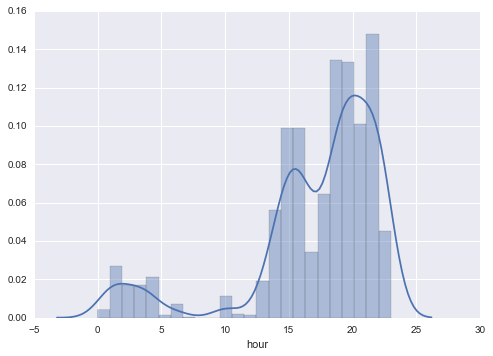

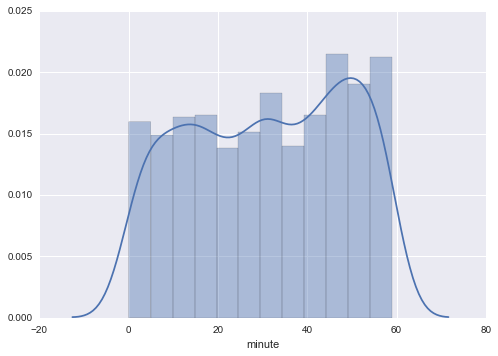

In [78]:
sns.distplot(data['hour'])
plt.show()
sns.distplot(data['minute'])
plt.show()

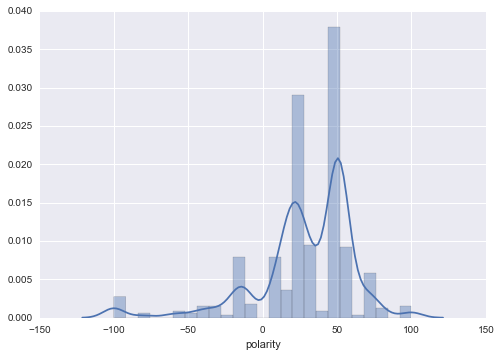

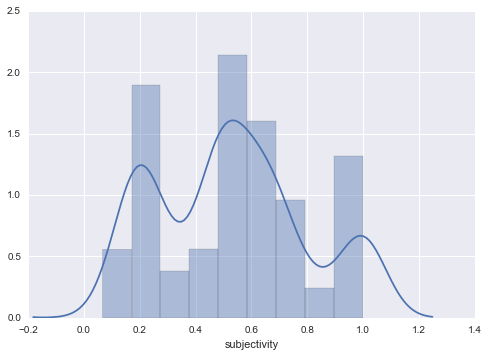

In [79]:
sns.distplot(data[data['polarity'] != 0]['polarity'])
plt.show()
sns.distplot(data[data['subjectivity'] > 0]['subjectivity'])
plt.show()

In [22]:
# data[data['polarity'] != 0].polarity.value_counts()

In [6]:
'Mean polarity: {}, mean subjectivity: {}'.format(np.mean(data[data['polarity'] != 0.00]['polarity']), np.mean(data[data['subjectivity'] != 0.00]['subjectivity']))

'Mean polarity: 28.5676594702, mean subjectivity: 0.52845615651'

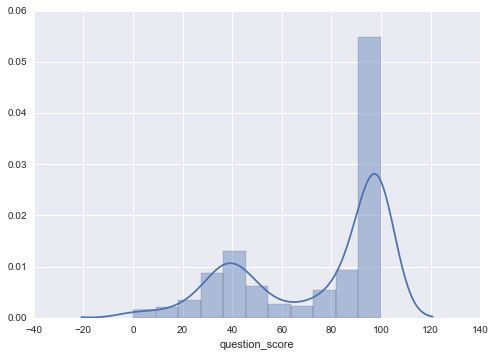

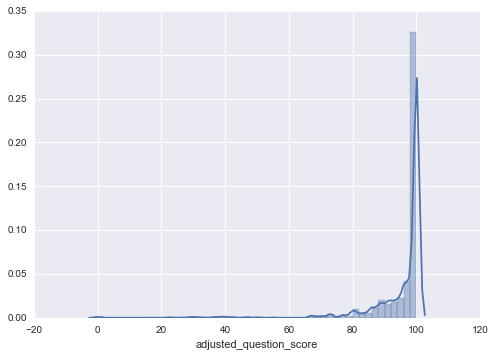

In [80]:
sns.distplot(data['question_score'])
plt.show()
sns.distplot(data['adjusted_question_score'])
plt.show()

In [9]:
data.corr()

,question_score,adjusted_question_score,from_bot,subjectivity,polarity,hour,minute
question_score,1.000000,-0.012023,NaN,-0.066135,-0.013780,0.038332,-0.101878
adjusted_question_score,-0.012023,1.000000,NaN,0.044245,0.113943,-0.040451,-0.034284
from_bot,NaN,NaN,NaN,NaN,NaN,NaN,NaN
subjectivity,-0.066135,0.044245,NaN,1.000000,0.514387,0.014713,0.046812
polarity,-0.013780,0.113943,NaN,0.514387,1.000000,-0.019870,-0.005541
hour,0.038332,-0.040451,NaN,0.014713,-0.019870,1.000000,-0.166533
minute,-0.101878,-0.034284,NaN,0.046812,-0.005541,-0.166533,1.000000


/Users/s.delesque/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


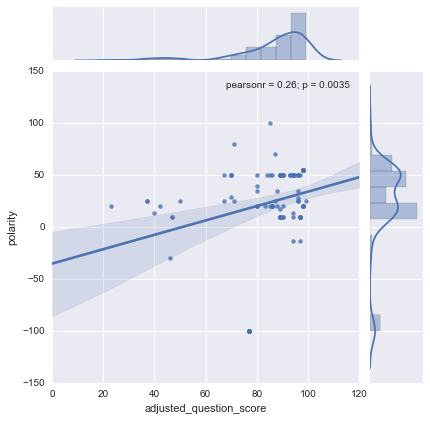

In [81]:
polarity_score_data = data[data.adjusted_question_score != 0][data.adjusted_question_score != 100][data.polarity != 0]
sns.jointplot(y='polarity', x='adjusted_question_score', data=polarity_score_data, kind="reg")

/Users/s.delesque/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


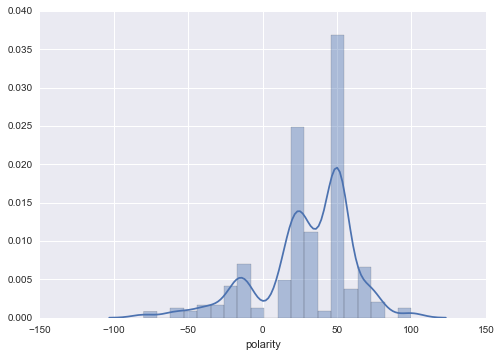

In [8]:
sns.distplot(data[data['adjusted_question_score'] == 100][data.polarity!=0]['polarity'])
plt.show()

In [4]:
questions = pd.DataFrame(list(dbcon['chatbox-dev'].questions.find()), columns=['text']).dropna()

In [7]:
questions.head()

,text
0,How many of my videos are private?
1,what's your name?
2,How much did I earn from claim?
3,How many viewers are tuned in to my live right...
4,In what country am I most popular?


In [9]:
questions.to_csv('./baily_questions.csv', encoding='utf-8')

In [11]:
history_fields = ['text', 'question_score', 'adjusted_question_score', 'from_bot', '_created']
history = pd.DataFrame(list(dbcon['chatbox-dev'].history.find()), columns=history_fields)
history.to_csv('./baily_history.csv', encoding='utf-8')